In [2]:
import numpy as np
import torch
import ultralytics
import tensorboard
import roboflow
print(np.__version__)
print(torch.__version__)
print(ultralytics.__version__)
print(tensorboard.__version__)
print(roboflow.__version__)
print("Numpy dtype available?", hasattr(np, "dtypes"))  # ✅ HARUS TRUE

1.26.4
2.0.1+cu117
8.3.156
2.10.1
1.1.63
Numpy dtype available? True


### Downloading the dataset from roboflow

In [32]:
import os
import shutil
from roboflow import Roboflow

# Download with default method
rf = Roboflow(api_key="s7vHWyxqUDG4pPQUNZ1A")
project = rf.workspace("jason-workspace-krcmo").project("pothole_detection-hfnqo-xmx8j")
version = project.version(3)
dataset = version.download("yolov8")

# Define source and destination paths
src = dataset.location
dst = "F:/CV"  # custom target folder

# Make sure destination parent directory exists
os.makedirs(os.path.dirname(dst), exist_ok=True)

# Move the entire folder
shutil.move(src, dst)

print(f"Dataset moved to: {dst}")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Pothole_Detection-3 in yolov8:: 100%|██████████| 8388/8388 [00:09<00:00, 842.69it/s] 


Dataset moved to: F:/CV


### Location of the dataset

In [1]:
import os
dataset_location = "F:/CV/Pothole_Detection-3"  # Ganti sesuai lokasi dataset hasil download
image_dir = os.path.join(dataset_location, "train/images")

### Check the average pixel of the train images

Total images: 2934
Min size: 160x120, Max size: 5760x3840
Average size: 1347x993


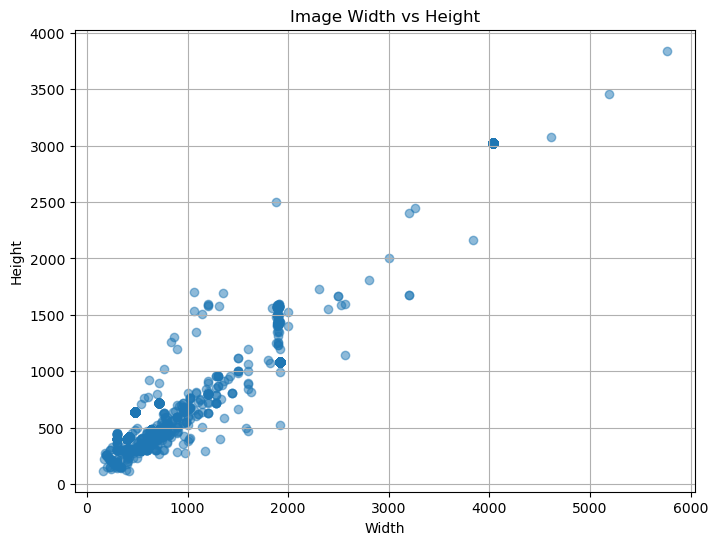

In [3]:
import cv2
import matplotlib.pyplot as plt

# List to store width and height
widths = []
heights = []

# Iterate through images
for filename in os.listdir(image_dir):
    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        path = os.path.join(image_dir, filename)
        img = cv2.imread(path)
        if img is not None:
            h, w = img.shape[:2]
            heights.append(h)
            widths.append(w)
        else:
            print(f"Failed to read {filename}")

# Print some stats
print(f"Total images: {len(widths)}")
print(f"Min size: {min(widths)}x{min(heights)}, Max size: {max(widths)}x{max(heights)}")
print(f"Average size: {sum(widths)//len(widths)}x{sum(heights)//len(heights)}")

# Scatter plot of image sizes
plt.figure(figsize=(8,6))
plt.scatter(widths, heights, alpha=0.5)
plt.xlabel("Width")
plt.ylabel("Height")
plt.title("Image Width vs Height")
plt.grid(True)
plt.show()

### Check each class and split distibution

In [4]:
import os
import yaml

# Load class names from data.yaml
data_yaml_path = os.path.join(dataset_location, "data.yaml")
with open(data_yaml_path) as f:
    data = yaml.safe_load(f)
    class_names = {i: name.lower() for i, name in enumerate(data["names"])}
    print("All Class Names:", class_names)

# Define the selected classes you want to count
selected_classes = {'crack', 'patch', 'pothole'}
filtered_class_names = {k: v for k, v in class_names.items() if v in selected_classes}
print("\nSelected Classes:", filtered_class_names)

# Initialize counters for selected classes
class_counts = {name: 0 for name in selected_classes}

# Define the dataset splits to check
splits = ['train', 'valid', 'test']
# Initialize per-split class counts
split_class_counts = {
    split: {name: 0 for name in selected_classes}
    for split in splits
}
# Count class instances in labels across all splits
for split in splits:
    labels_dir = os.path.join(dataset_location, split, "labels")
    if not os.path.exists(labels_dir):
        print(f"⚠️ Labels directory not found: {labels_dir}")
        continue

    for txt_file in os.listdir(labels_dir):
        txt_path = os.path.join(labels_dir, txt_file)
        try:
            with open(txt_path) as f:
                for line in f:
                    if line.strip():
                        class_id = int(line.split()[0])
                        class_name = class_names.get(class_id, '')
                        if class_name in selected_classes:
                            split_class_counts[split][class_name] += 1
                            class_counts[class_name] += 1  # ✅ Tambahkan ini!
        except FileNotFoundError:
            continue

# === Print summary ===
print("\n📊 Class Counts Per Split:")
for split in splits:
    print(f"\n🔹 {split.upper()}:")
    for class_name in sorted(selected_classes):
        count = split_class_counts[split][class_name]
        print(f"  {class_name}: {count}")
# Output class counts
print("\nClass Counts Across train/valid/test (Selected Classes):")
for name, count in sorted(class_counts.items()):
    print(f"{name}: {count}")

All Class Names: {0: 'crack', 1: 'patch', 2: 'pothole'}

Selected Classes: {0: 'crack', 1: 'patch', 2: 'pothole'}

📊 Class Counts Per Split:

🔹 TRAIN:
  crack: 4019
  patch: 2156
  pothole: 3493

🔹 VALID:
  crack: 1114
  patch: 470
  pothole: 926

🔹 TEST:
  crack: 512
  patch: 240
  pothole: 335

Class Counts Across train/valid/test (Selected Classes):
crack: 5645
patch: 2866
pothole: 4754


### Visualize the dataset

In [ ]:
from matplotlib.patches import Rectangle
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
import numpy as np
import random
import os
import yaml

# Load class names from data.yaml
data_yaml_path = os.path.join(dataset_location, "data.yaml")
with open(data_yaml_path) as f:
    data = yaml.safe_load(f)
    class_names = {i: name.lower() for i, name in enumerate(data["names"])}
    print("All Class Names:", class_names)

# Define selected classes
selected_classes = {'crack', 'patch', 'pothole'}
filtered_class_names = {k: v for k, v in class_names.items() if v in selected_classes}
print("\nSelected Classes:", filtered_class_names)

# Assign unique colors to each selected class
selected_classes = sorted(selected_classes)  # consistent ordering
class_colors = {
    'crack': '#e41a1c',       # Red
    'patch': '#377eb8',  # Blue
    'pothole': '#4daf4a'      # Green
}

# Prepare valid images
annotations_dir = os.path.join(dataset_location, "train")  # or "valid"/"test"
image_dir = os.path.join(annotations_dir, "images")
valid_images = []

for img_file in os.listdir(image_dir):
    if not img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
        continue

    txt_file = os.path.splitext(img_file)[0] + ".txt"
    txt_path = os.path.join(annotations_dir, "labels", txt_file)

    if not os.path.exists(txt_path):
        continue

    with open(txt_path) as f:
        for line in f:
            if line.strip():
                class_id = int(line.split()[0])
                if class_names.get(class_id, '') in selected_classes:
                    valid_images.append(img_file)
                    break

# Create plot with bounding boxes
plt.figure(figsize=(15, 15))
for i, img_file in enumerate(random.sample(valid_images, min(9, len(valid_images))), 1):
    img_path = os.path.join(image_dir, img_file)
    txt_path = os.path.join(annotations_dir, "labels", os.path.splitext(img_file)[0] + ".txt")

    try:
        # Load image
        img = mpimg.imread(img_path)
        img_height, img_width = img.shape[0], img.shape[1]

        # Create subplot
        ax = plt.subplot(3, 3, i)
        ax.imshow(img)
        ax.axis('off')

        # Get class labels and draw bounding boxes
        labels = set()
        if os.path.exists(txt_path):
            with open(txt_path) as f:
                for line in f:
                    if line.strip():
                        parts = line.strip().split()
                        class_id = int(parts[0])
                        class_name = class_names.get(class_id, '')

                        if class_name in selected_classes:
                            # Convert YOLO format to image coordinates
                            x_center = float(parts[1]) * img_width
                            y_center = float(parts[2]) * img_height
                            box_width = float(parts[3]) * img_width
                            box_height = float(parts[4]) * img_height

                            # Calculate rectangle coordinates
                            x = x_center - (box_width / 2)
                            y = y_center - (box_height / 2)

                            color = class_colors.get(class_name, (1, 0, 0))  # fallback to red

                            # Draw bounding box
                            rect = Rectangle(
                                (x, y),
                                box_width,
                                box_height,
                                linewidth=2,
                                edgecolor=color,
                                facecolor='none'
                            )
                            ax.add_patch(rect)

                            # Add label
                            ax.text(
                                x,
                                y - 5,
                                class_name,
                                color='white',
                                fontsize=10,
                                bbox=dict(facecolor=color, alpha=0.8, edgecolor='none')
                            )

                            labels.add(class_name)

        plt.title(", ".join(labels) if labels else "No selected objects", fontsize=10)

    except Exception as e:
        print(f"Error processing {img_file}: {str(e)}")
        continue

plt.tight_layout()
plt.show()


### Training the model

In [6]:
from ultralytics import YOLO
import os
import numpy as np

model = YOLO('yolov8s.pt')  # atau ganti dengan model lain

model.train(
    data=dataset_location+'/data.yaml',
    epochs=100,
    imgsz=512,
    batch=8,
    device=0,
    name='Road Damage Detection'
)

print("Training completed!")

New https://pypi.org/project/ultralytics/8.3.157 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.156  Python-3.10.14 torch-2.0.1+cu117 CUDA:0 (NVIDIA GeForce GTX 1650, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=F:/CV/Pothole_Detection-3/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=Road Damage Detection, nbs=64, nms=

train: Scanning F:\CV\Pothole_Detection-3\train\labels.cache... 2934 images, 202 backgrounds, 0 corrupt: 100%|██████████| 2934/2934 [00:00<?, ?it/s]

WARNING Box and segment counts should be equal, but got len(segments) = 2, len(boxes) = 9668. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


albumentations: ImageCompression.__init__() got an unexpected keyword argument 'quality_range'
val: Fast image access  (ping: 0.20.1 ms, read: 534.0512.0 MB/s, size: 1173.2 KB)


val: Scanning F:\CV\Pothole_Detection-3\valid\labels.cache... 834 images, 46 backgrounds, 0 corrupt: 100%|██████████| 834/834 [00:00<?, ?it/s]

WARNING Box and segment counts should be equal, but got len(segments) = 1, len(boxes) = 2510. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


Plotting labels to runs\detect\Road Damage Detection\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 512 train, 512 val
Using 8 dataloader workers
Logging results to runs\detect\Road Damage Detection
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.23G      2.057      2.719      1.831         40        512: 100%|██████████| 367/367 [02:13<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:13<00:00,  4.07it/s]


                   all        834       2510      0.223      0.243      0.145     0.0608

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.32G       2.07       2.47      1.875         30        512: 100%|██████████| 367/367 [02:07<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:12<00:00,  4.21it/s]

                   all        834       2510      0.344      0.279      0.249      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.22G      2.065      2.445      1.865         57        512: 100%|██████████| 367/367 [02:04<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:12<00:00,  4.13it/s]

                   all        834       2510      0.298      0.333      0.291      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.22G      2.021      2.375      1.847         42        512: 100%|██████████| 367/367 [02:06<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:14<00:00,  3.65it/s]


                   all        834       2510      0.367      0.293      0.276      0.137

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.22G      1.977      2.315      1.809         28        512: 100%|██████████| 367/367 [02:06<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:12<00:00,  4.35it/s]


                   all        834       2510      0.453      0.331      0.314      0.152

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.22G       1.94      2.235      1.769         20        512: 100%|██████████| 367/367 [02:05<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:12<00:00,  4.29it/s]

                   all        834       2510      0.488      0.359      0.366      0.186



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.22G      1.882      2.155      1.729         43        512: 100%|██████████| 367/367 [02:06<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:12<00:00,  4.19it/s]

                   all        834       2510       0.56      0.362       0.39      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.22G      1.882      2.126      1.734         37        512: 100%|██████████| 367/367 [02:05<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:12<00:00,  4.26it/s]

                   all        834       2510      0.458      0.358      0.352      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.22G      1.828      2.042      1.704         43        512: 100%|██████████| 367/367 [02:05<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:12<00:00,  4.30it/s]

                   all        834       2510      0.496      0.375      0.385      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.22G      1.833      2.058      1.696         29        512: 100%|██████████| 367/367 [02:05<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:12<00:00,  4.19it/s]

                   all        834       2510      0.543      0.398      0.425      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.32G       1.81      1.986      1.662         32        512: 100%|██████████| 367/367 [02:05<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:12<00:00,  4.29it/s]

                   all        834       2510      0.559      0.399      0.426      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.22G      1.798      1.971      1.669         38        512: 100%|██████████| 367/367 [02:05<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:12<00:00,  4.27it/s]

                   all        834       2510      0.507       0.46       0.45      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.23G      1.775      1.926      1.645         34        512: 100%|██████████| 367/367 [02:06<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:12<00:00,  4.26it/s]

                   all        834       2510      0.544      0.452      0.467      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.23G      1.752      1.892      1.625         20        512: 100%|██████████| 367/367 [02:06<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:12<00:00,  4.08it/s]

                   all        834       2510      0.497      0.451      0.456      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.22G      1.747      1.889      1.626         49        512: 100%|██████████| 367/367 [02:08<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:13<00:00,  3.92it/s]

                   all        834       2510      0.567      0.463      0.473      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.22G      1.716      1.842      1.605         26        512: 100%|██████████| 367/367 [02:09<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:13<00:00,  3.94it/s]

                   all        834       2510       0.53      0.498      0.485      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.22G      1.725      1.824      1.611         44        512: 100%|██████████| 367/367 [02:06<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:12<00:00,  4.28it/s]

                   all        834       2510      0.554      0.459      0.473      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.22G        1.7      1.825      1.598         23        512: 100%|██████████| 367/367 [02:05<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:12<00:00,  4.24it/s]

                   all        834       2510      0.573      0.466      0.491      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.32G      1.716      1.808      1.592         22        512: 100%|██████████| 367/367 [02:05<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:12<00:00,  4.11it/s]

                   all        834       2510      0.567       0.49      0.504      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.22G      1.677      1.756      1.571         40        512: 100%|██████████| 367/367 [02:05<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:12<00:00,  4.27it/s]

                   all        834       2510      0.586      0.479      0.499      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.23G      1.664      1.738      1.572         29        512: 100%|██████████| 367/367 [02:05<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:12<00:00,  4.31it/s]

                   all        834       2510      0.568      0.485      0.497      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.22G      1.658      1.744      1.569         32        512: 100%|██████████| 367/367 [02:05<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:11<00:00,  4.42it/s]

                   all        834       2510      0.596      0.514      0.531      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.21G      1.651      1.725      1.556         48        512: 100%|██████████| 367/367 [02:06<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:12<00:00,  4.41it/s]

                   all        834       2510      0.583       0.51      0.516       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.22G       1.63      1.687      1.547         29        512: 100%|██████████| 367/367 [02:06<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:12<00:00,  4.23it/s]

                   all        834       2510      0.565      0.495      0.495      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.22G      1.622      1.676      1.532         34        512: 100%|██████████| 367/367 [02:06<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:13<00:00,  3.93it/s]

                   all        834       2510      0.547      0.518      0.504      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.21G      1.636      1.684       1.55         25        512: 100%|██████████| 367/367 [02:08<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:13<00:00,  3.92it/s]

                   all        834       2510      0.595      0.525       0.53      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.32G      1.613      1.646       1.53         37        512: 100%|██████████| 367/367 [02:07<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:12<00:00,  4.35it/s]

                   all        834       2510       0.61      0.509      0.535      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.22G      1.603      1.632      1.526         38        512: 100%|██████████| 367/367 [02:05<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:12<00:00,  4.28it/s]

                   all        834       2510        0.6      0.524      0.527      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.23G      1.603      1.644      1.523         17        512: 100%|██████████| 367/367 [02:08<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:12<00:00,  4.31it/s]

                   all        834       2510      0.638       0.52      0.538      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.23G      1.587      1.616      1.517         25        512: 100%|██████████| 367/367 [02:09<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:13<00:00,  3.95it/s]

                   all        834       2510      0.575      0.536      0.537      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.22G      1.582      1.615      1.515         25        512: 100%|██████████| 367/367 [02:08<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:13<00:00,  3.94it/s]

                   all        834       2510      0.623      0.532      0.533      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.22G      1.589      1.597       1.51         28        512: 100%|██████████| 367/367 [02:06<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:12<00:00,  4.15it/s]

                   all        834       2510       0.62       0.53      0.548      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.22G       1.55      1.547      1.489         44        512: 100%|██████████| 367/367 [02:07<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:12<00:00,  4.15it/s]

                   all        834       2510      0.644      0.532      0.552      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.22G      1.556      1.552      1.492         36        512: 100%|██████████| 367/367 [02:07<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:12<00:00,  4.13it/s]

                   all        834       2510      0.636      0.531       0.55      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.32G      1.557      1.547      1.486         42        512: 100%|██████████| 367/367 [02:06<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:12<00:00,  4.40it/s]

                   all        834       2510       0.64      0.528      0.561      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.22G      1.554      1.526      1.486         33        512: 100%|██████████| 367/367 [02:05<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:12<00:00,  4.40it/s]

                   all        834       2510      0.649      0.539      0.553      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.23G      1.534      1.523      1.478         32        512: 100%|██████████| 367/367 [02:05<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:12<00:00,  4.36it/s]

                   all        834       2510      0.631      0.547      0.563      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.23G      1.536      1.516      1.474         32        512: 100%|██████████| 367/367 [02:05<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:11<00:00,  4.46it/s]

                   all        834       2510      0.638      0.541      0.565      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.22G      1.513      1.485      1.441         53        512: 100%|██████████| 367/367 [02:04<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:12<00:00,  4.36it/s]

                   all        834       2510      0.646      0.555      0.574      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.22G      1.502      1.464      1.456         45        512: 100%|██████████| 367/367 [02:05<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:11<00:00,  4.42it/s]

                   all        834       2510      0.666      0.543      0.569      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.22G      1.512      1.476      1.456         25        512: 100%|██████████| 367/367 [02:05<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:12<00:00,  4.39it/s]

                   all        834       2510      0.626      0.556      0.566      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.22G      1.516      1.477      1.458         53        512: 100%|██████████| 367/367 [02:05<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:12<00:00,  4.31it/s]

                   all        834       2510      0.641      0.564      0.571      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.32G      1.486      1.446      1.438         19        512: 100%|██████████| 367/367 [02:05<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:12<00:00,  4.28it/s]

                   all        834       2510      0.639      0.561      0.582      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.22G      1.481      1.418      1.435         43        512: 100%|██████████| 367/367 [02:05<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:12<00:00,  4.20it/s]

                   all        834       2510      0.641      0.567      0.576      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.23G      1.473      1.419      1.434         18        512: 100%|██████████| 367/367 [02:04<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:12<00:00,  4.41it/s]

                   all        834       2510      0.702      0.536      0.581      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.23G      1.474        1.4      1.431         22        512: 100%|██████████| 367/367 [02:05<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:12<00:00,  4.37it/s]

                   all        834       2510      0.684      0.545       0.58       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.22G      1.466      1.416      1.431         36        512: 100%|██████████| 367/367 [02:05<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:12<00:00,  4.36it/s]

                   all        834       2510      0.642      0.553      0.568       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.22G      1.463      1.394      1.419         50        512: 100%|██████████| 367/367 [02:04<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:12<00:00,  4.34it/s]

                   all        834       2510      0.683      0.558      0.589      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.22G      1.454      1.391       1.42         42        512: 100%|██████████| 367/367 [02:07<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:12<00:00,  4.16it/s]

                   all        834       2510      0.689      0.557      0.592      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.22G      1.437      1.363      1.405         41        512: 100%|██████████| 367/367 [02:07<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:12<00:00,  4.20it/s]

                   all        834       2510      0.682      0.561      0.596      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.32G      1.441      1.335      1.398         38        512: 100%|██████████| 367/367 [02:07<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:12<00:00,  4.11it/s]

                   all        834       2510      0.677      0.566      0.588      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.22G      1.425      1.335      1.394         75        512: 100%|██████████| 367/367 [02:07<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:12<00:00,  4.09it/s]

                   all        834       2510      0.669      0.585      0.598      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.23G      1.432      1.338      1.398         38        512: 100%|██████████| 367/367 [02:06<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:11<00:00,  4.42it/s]

                   all        834       2510      0.658      0.584      0.595      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.23G      1.411      1.292      1.379         54        512: 100%|██████████| 367/367 [02:06<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:12<00:00,  4.14it/s]

                   all        834       2510      0.693      0.571        0.6      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.22G      1.401      1.305      1.384         35        512: 100%|██████████| 367/367 [02:07<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:12<00:00,  4.25it/s]

                   all        834       2510      0.698      0.579      0.609      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.22G      1.393      1.292       1.38         27        512: 100%|██████████| 367/367 [02:08<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:12<00:00,  4.23it/s]

                   all        834       2510      0.673      0.581      0.596      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.22G       1.39      1.286      1.377         30        512: 100%|██████████| 367/367 [02:08<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:13<00:00,  3.93it/s]

                   all        834       2510      0.663       0.58        0.6      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.22G      1.394      1.271      1.366         19        512: 100%|██████████| 367/367 [02:07<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:13<00:00,  3.87it/s]

                   all        834       2510      0.689      0.569      0.598      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.32G      1.392       1.29      1.371         36        512: 100%|██████████| 367/367 [02:08<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:13<00:00,  3.95it/s]

                   all        834       2510      0.704       0.58      0.612       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.22G      1.388      1.276      1.365         67        512: 100%|██████████| 367/367 [02:08<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:12<00:00,  4.14it/s]

                   all        834       2510       0.68      0.584      0.608      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.23G      1.367      1.248      1.359         44        512: 100%|██████████| 367/367 [02:06<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:11<00:00,  4.43it/s]

                   all        834       2510      0.675      0.579      0.601      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.23G      1.366      1.241      1.348         35        512: 100%|██████████| 367/367 [02:06<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:12<00:00,  4.13it/s]

                   all        834       2510      0.669       0.59      0.609      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.22G      1.364      1.216      1.352         68        512: 100%|██████████| 367/367 [02:07<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:12<00:00,  4.13it/s]

                   all        834       2510        0.7      0.591      0.616      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.22G      1.352      1.231      1.338         31        512: 100%|██████████| 367/367 [02:08<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:13<00:00,  4.00it/s]

                   all        834       2510      0.688      0.585      0.612      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.22G      1.348      1.225      1.343         19        512: 100%|██████████| 367/367 [02:08<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:12<00:00,  4.18it/s]

                   all        834       2510      0.676      0.588      0.611      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.22G      1.321      1.196      1.326         38        512: 100%|██████████| 367/367 [02:07<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:13<00:00,  3.89it/s]

                   all        834       2510      0.675      0.602      0.619      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.32G      1.339      1.207      1.332         26        512: 100%|██████████| 367/367 [02:06<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:12<00:00,  4.32it/s]

                   all        834       2510      0.705      0.576      0.607      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.22G      1.328      1.172      1.319         42        512: 100%|██████████| 367/367 [02:05<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:12<00:00,  4.36it/s]

                   all        834       2510      0.682      0.597       0.61      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.23G      1.323      1.165      1.321         47        512: 100%|██████████| 367/367 [02:06<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:12<00:00,  4.23it/s]

                   all        834       2510      0.678      0.593      0.612       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.23G      1.324      1.175      1.321         20        512: 100%|██████████| 367/367 [02:06<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:12<00:00,  4.37it/s]

                   all        834       2510      0.707      0.581      0.605      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.22G      1.307      1.164      1.313         15        512: 100%|██████████| 367/367 [02:07<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:12<00:00,  4.14it/s]

                   all        834       2510      0.689       0.59      0.615      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.22G      1.298      1.145      1.304         27        512: 100%|██████████| 367/367 [02:07<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:12<00:00,  4.30it/s]

                   all        834       2510      0.722      0.571      0.614      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.22G      1.297      1.149      1.305         66        512: 100%|██████████| 367/367 [02:06<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:12<00:00,  4.31it/s]

                   all        834       2510      0.697      0.587      0.622      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.22G      1.282      1.141      1.299         34        512: 100%|██████████| 367/367 [02:05<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:12<00:00,  4.30it/s]

                   all        834       2510      0.711       0.58      0.617      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.32G      1.281      1.124      1.293         22        512: 100%|██████████| 367/367 [02:05<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:13<00:00,  3.91it/s]

                   all        834       2510      0.709      0.588      0.619      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.22G      1.279      1.119      1.293         53        512: 100%|██████████| 367/367 [02:06<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:13<00:00,  4.07it/s]

                   all        834       2510      0.715      0.589      0.626      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.23G      1.277      1.112      1.292         28        512: 100%|██████████| 367/367 [02:06<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:12<00:00,  4.31it/s]

                   all        834       2510      0.699      0.608      0.627      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.23G      1.256      1.082      1.274         34        512: 100%|██████████| 367/367 [02:06<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:12<00:00,  4.11it/s]

                   all        834       2510      0.695      0.601      0.624       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.22G      1.248      1.078      1.277         34        512: 100%|██████████| 367/367 [02:05<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:12<00:00,  4.31it/s]

                   all        834       2510      0.698      0.614       0.63      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.22G      1.252       1.08      1.278         24        512: 100%|██████████| 367/367 [02:05<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:12<00:00,  4.36it/s]

                   all        834       2510      0.706      0.607      0.629      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.22G      1.243      1.074      1.271         45        512: 100%|██████████| 367/367 [02:05<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:12<00:00,  4.35it/s]

                   all        834       2510      0.734      0.586      0.629      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.22G      1.242      1.059      1.268         30        512: 100%|██████████| 367/367 [02:07<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:12<00:00,  4.22it/s]

                   all        834       2510      0.724      0.594      0.624      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.32G      1.227      1.044      1.253         50        512: 100%|██████████| 367/367 [02:06<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:12<00:00,  4.26it/s]

                   all        834       2510      0.739      0.587      0.629      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.22G       1.24      1.062      1.267         35        512: 100%|██████████| 367/367 [02:05<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:12<00:00,  4.35it/s]

                   all        834       2510      0.731      0.596      0.633      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.23G      1.227      1.033      1.252         52        512: 100%|██████████| 367/367 [02:09<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:13<00:00,  3.99it/s]

                   all        834       2510      0.723      0.591      0.628      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.23G      1.225       1.04      1.258         25        512: 100%|██████████| 367/367 [02:09<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:13<00:00,  4.02it/s]

                   all        834       2510      0.713      0.599       0.63      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.22G      1.214      1.031      1.243         30        512: 100%|██████████| 367/367 [02:09<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:13<00:00,  3.97it/s]

                   all        834       2510      0.708      0.614      0.635      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.22G      1.201      1.012      1.244         25        512: 100%|██████████| 367/367 [02:07<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:12<00:00,  4.39it/s]

                   all        834       2510      0.715      0.611      0.631      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.22G       1.19      1.009      1.236         36        512: 100%|██████████| 367/367 [02:05<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:12<00:00,  4.25it/s]

                   all        834       2510      0.707      0.611      0.631       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.21G      1.204      1.012      1.243         33        512: 100%|██████████| 367/367 [02:07<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:12<00:00,  4.23it/s]

                   all        834       2510      0.707      0.617      0.632       0.37


Closing dataloader mosaic
albumentations: ImageCompression.__init__() got an unexpected keyword argument 'quality_range'

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.32G      1.199     0.9634      1.235         17        512: 100%|██████████| 367/367 [02:06<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:13<00:00,  4.02it/s]

                   all        834       2510      0.726      0.596      0.629      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.22G      1.169     0.9081      1.223         12        512: 100%|██████████| 367/367 [02:07<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:12<00:00,  4.32it/s]

                   all        834       2510      0.695      0.614       0.63      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.23G      1.143     0.8932      1.208         28        512: 100%|██████████| 367/367 [02:06<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:12<00:00,  4.16it/s]

                   all        834       2510      0.716      0.606      0.631       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.22G      1.131     0.8753      1.195         21        512: 100%|██████████| 367/367 [02:06<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:11<00:00,  4.77it/s]

                   all        834       2510      0.723      0.611      0.635      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.21G      1.126       0.87      1.195         14        512: 100%|██████████| 367/367 [02:04<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:11<00:00,  4.43it/s]

                   all        834       2510      0.738      0.595      0.634      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.22G      1.121     0.8543      1.193         14        512: 100%|██████████| 367/367 [02:05<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:12<00:00,  4.42it/s]

                   all        834       2510      0.732      0.601      0.637      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.22G      1.108     0.8403      1.183         28        512: 100%|██████████| 367/367 [02:05<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:12<00:00,  4.21it/s]

                   all        834       2510      0.733      0.604      0.639      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.23G      1.096     0.8396      1.178         12        512: 100%|██████████| 367/367 [02:04<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:11<00:00,  4.43it/s]

                   all        834       2510      0.736      0.602      0.637      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.32G      1.093     0.8301      1.174         13        512: 100%|██████████| 367/367 [02:04<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:12<00:00,  4.36it/s]

                   all        834       2510      0.726      0.611      0.639      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.22G      1.086     0.8241      1.168         19        512: 100%|██████████| 367/367 [02:05<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:12<00:00,  4.33it/s]

                   all        834       2510      0.733      0.602      0.641      0.376



100 epochs completed in 3.900 hours.
Optimizer stripped from runs\detect\Road Damage Detection\weights\last.pt, 22.5MB
Optimizer stripped from runs\detect\Road Damage Detection\weights\best.pt, 22.5MB

Validating runs\detect\Road Damage Detection\weights\best.pt...
Ultralytics 8.3.156  Python-3.10.14 torch-2.0.1+cu117 CUDA:0 (NVIDIA GeForce GTX 1650, 4096MiB)
Model summary (fused): 72 layers, 11,126,745 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:11<00:00,  4.44it/s]


                   all        834       2510      0.735      0.602      0.637      0.378
                 crack        474       1114      0.608      0.429      0.447      0.198
                 patch        351        470      0.808      0.685      0.719      0.491
               pothole        277        926       0.79      0.691      0.746      0.444
Speed: 0.2ms preprocess, 7.5ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs\detect\Road Damage Detection
Training completed!


### Example of Model Prediction

In [9]:
from ultralytics import YOLO
import os
import shutil

# Optional: Clear any old temp video
if os.path.exists("temp_video.mp4"):
    os.remove("temp_video.mp4")

# Load model (make sure this path is correct)
model = YOLO('runs/detect/Road Damage Detection/weights/best.pt')  # or last.pt

def youtube_predict(url):
    try:
        print("🔄 Attempting direct YouTube prediction (stream mode)...")

        # WARNING: This often fails in newer versions of Ultralytics
        # due to bugs or YouTube restrictions. We'll skip this and move to fallback.

        raise Exception("Skipping direct prediction due to known YOLO+YouTube bugs.")

    except Exception as e:
        print(f"⚠️ Direct prediction failed: {e}")
        print("🔄 Trying fallback: downloading video first using yt-dlp...")

        # Download the video using yt-dlp with a generic MP4 format
        download_cmd = f'yt-dlp -f mp4 -o "temp_video.mp4" "{url}"'
        exit_code = os.system(download_cmd)

        if not os.path.exists("temp_video.mp4"):
            raise FileNotFoundError("❌ Failed to download video. Please check the URL or try another format.")

        print("📥 Video downloaded. Running YOLO prediction...")

        # Run prediction on the downloaded video
        results = model.predict(
            source="temp_video.mp4",
            conf=0.5,
            imgsz=512,
            device=0,    # or 'cpu' if you don't have GPU
            save=True    # Save output results
        )

        print("✅ YOLO prediction completed.")

        # Optionally remove temp video
        os.remove("temp_video.mp4")

        return results[0]  # Return the first result (can be changed to return all)

# Example usage:
youtube_url = 'https://www.youtube.com/watch?v=THQUs18B3R0'  # Replace with any valid YouTube URL
result = youtube_predict(youtube_url)

print(f"\n📂 Results saved to: {result.save_dir}")

🔄 Attempting direct YouTube prediction (stream mode)...
⚠️ Direct prediction failed: Skipping direct prediction due to known YOLO+YouTube bugs.
🔄 Trying fallback: downloading video first using yt-dlp...
📥 Video downloaded. Running YOLO prediction...

WARNING 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/3996) C:\Users\ASUS TUF GAMING\python\CV\temp_video.mp4: 288x512 5 potholes, 983.6ms
video 1/1 (frame 2/3996) C:\Users\ASUS TUF GAMING\python\CV\temp_video.mp4: 288x512 5 potholes, 9.0ms
vid

### Fine Tuning

In [6]:
from ultralytics import YOLO
import os
import numpy as np

model = YOLO('yolov8s.pt')  # atau ganti dengan model lain

model.train(
    data=dataset_location+'/data.yaml',
    epochs=100,
    imgsz=640,
    batch=8,
    device=0,
    name='Road Damage Detection-2'
)

print("Training completed!")

New https://pypi.org/project/ultralytics/8.3.158 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.156  Python-3.10.14 torch-2.0.1+cu117 CUDA:0 (NVIDIA GeForce GTX 1650, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=F:/CV/Pothole_Detection-3/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=Road Damage Detection-2, nbs=64, nm

train: Scanning F:\CV\Pothole_Detection-3\train\labels.cache... 2934 images, 202 backgrounds, 0 corrupt: 100%|██████████| 2934/2934 [00:00<?, ?it/s]

WARNING Box and segment counts should be equal, but got len(segments) = 2, len(boxes) = 9668. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


albumentations: ImageCompression.__init__() got an unexpected keyword argument 'quality_range'
val: Fast image access  (ping: 1.20.4 ms, read: 13.714.4 MB/s, size: 1173.2 KB)


val: Scanning F:\CV\Pothole_Detection-3\valid\labels.cache... 834 images, 46 backgrounds, 0 corrupt: 100%|██████████| 834/834 [00:00<?, ?it/s]

WARNING Box and segment counts should be equal, but got len(segments) = 1, len(boxes) = 2510. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


Plotting labels to runs\detect\Road Damage Detection-2\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\Road Damage Detection-2
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      3.44G      2.057      2.813      1.894         40        640: 100%|██████████| 367/367 [03:22<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:18<00:00,  2.94it/s]


                   all        834       2510      0.312      0.255      0.191     0.0807

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      3.33G      2.078      2.572      1.939         30        640: 100%|██████████| 367/367 [03:11<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:15<00:00,  3.39it/s]


                   all        834       2510      0.468      0.271      0.273      0.119

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      3.34G      2.079      2.532      1.928         57        640: 100%|██████████| 367/367 [03:14<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:16<00:00,  3.31it/s]

                   all        834       2510      0.386        0.3      0.255      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      3.34G      2.039      2.482      1.919         41        640: 100%|██████████| 367/367 [03:16<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:15<00:00,  3.35it/s]

                   all        834       2510      0.485      0.315      0.304      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      3.33G      1.974       2.41      1.869         28        640: 100%|██████████| 367/367 [03:17<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:15<00:00,  3.32it/s]


                   all        834       2510      0.456       0.32      0.299       0.14

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      3.33G      1.944      2.315       1.84         20        640: 100%|██████████| 367/367 [03:18<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:16<00:00,  3.22it/s]


                   all        834       2510      0.435      0.379      0.353      0.168

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      3.33G      1.883      2.238      1.804         43        640: 100%|██████████| 367/367 [03:16<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:17<00:00,  3.07it/s]


                   all        834       2510      0.453      0.392       0.38      0.194

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      3.33G      1.884      2.211       1.81         37        640: 100%|██████████| 367/367 [03:17<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:16<00:00,  3.18it/s]


                   all        834       2510      0.563      0.382      0.411      0.204

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      3.33G      1.815      2.112      1.755         43        640: 100%|██████████| 367/367 [03:20<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:19<00:00,  2.71it/s]


                   all        834       2510      0.501      0.401      0.406      0.208

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      3.35G      1.815      2.125      1.754         29        640: 100%|██████████| 367/367 [03:18<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:16<00:00,  3.21it/s]


                   all        834       2510        0.5      0.417      0.413      0.216

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      3.33G      1.809      2.067      1.733         32        640: 100%|██████████| 367/367 [03:19<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:15<00:00,  3.53it/s]

                   all        834       2510      0.491      0.448      0.439      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      3.34G      1.779       2.04      1.734         38        640: 100%|██████████| 367/367 [03:16<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:15<00:00,  3.51it/s]

                   all        834       2510      0.517      0.452      0.434      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      3.33G       1.77          2      1.708         34        640: 100%|██████████| 367/367 [03:15<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:15<00:00,  3.40it/s]


                   all        834       2510      0.568      0.438      0.463      0.238

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      3.34G      1.754      1.958      1.679         20        640: 100%|██████████| 367/367 [03:15<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:14<00:00,  3.56it/s]

                   all        834       2510      0.574      0.458      0.469      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      3.33G      1.744      1.948      1.683         49        640: 100%|██████████| 367/367 [03:14<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:15<00:00,  3.53it/s]

                   all        834       2510      0.582      0.466      0.482      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      3.34G      1.723      1.906      1.667         27        640: 100%|██████████| 367/367 [03:14<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:14<00:00,  3.62it/s]

                   all        834       2510      0.546       0.46      0.476      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      3.33G      1.718      1.898      1.664         44        640: 100%|██████████| 367/367 [03:13<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:14<00:00,  3.59it/s]

                   all        834       2510       0.59       0.49      0.507       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      3.34G      1.693       1.88      1.654         23        640: 100%|██████████| 367/367 [03:13<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:14<00:00,  3.68it/s]

                   all        834       2510      0.602      0.494      0.504      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      3.33G       1.69      1.847      1.643         22        640: 100%|██████████| 367/367 [03:12<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:14<00:00,  3.61it/s]

                   all        834       2510      0.601      0.496      0.506      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      3.34G      1.665      1.818      1.625         41        640: 100%|██████████| 367/367 [03:12<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:14<00:00,  3.63it/s]

                   all        834       2510      0.578      0.501      0.512      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      3.33G      1.655       1.78      1.613         29        640: 100%|██████████| 367/367 [03:13<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:14<00:00,  3.64it/s]

                   all        834       2510      0.571      0.505      0.503      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      3.34G      1.655      1.796      1.615         32        640: 100%|██████████| 367/367 [03:12<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:14<00:00,  3.63it/s]

                   all        834       2510      0.587      0.502      0.502      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      3.34G      1.638      1.784      1.607         48        640: 100%|██████████| 367/367 [03:15<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:16<00:00,  3.31it/s]

                   all        834       2510      0.597      0.525      0.521      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      3.33G      1.611       1.75      1.592         29        640: 100%|██████████| 367/367 [03:13<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:14<00:00,  3.55it/s]

                   all        834       2510      0.596      0.503      0.517      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      3.34G      1.618      1.734      1.582         34        640: 100%|██████████| 367/367 [03:10<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:15<00:00,  3.46it/s]

                   all        834       2510      0.586      0.509      0.524      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      3.34G      1.621      1.729      1.591         25        640: 100%|██████████| 367/367 [03:12<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:14<00:00,  3.55it/s]

                   all        834       2510      0.591      0.532      0.538      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      3.33G      1.611      1.695      1.576         37        640: 100%|██████████| 367/367 [03:14<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:16<00:00,  3.30it/s]

                   all        834       2510      0.596      0.524      0.536      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      3.34G      1.609      1.683      1.583         38        640: 100%|██████████| 367/367 [03:14<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:14<00:00,  3.58it/s]

                   all        834       2510      0.607      0.524      0.539      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      3.33G      1.601      1.688      1.572         17        640: 100%|██████████| 367/367 [03:11<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:14<00:00,  3.62it/s]

                   all        834       2510      0.623      0.528      0.546      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      3.34G      1.574      1.658      1.562         25        640: 100%|██████████| 367/367 [03:11<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:14<00:00,  3.60it/s]

                   all        834       2510      0.601       0.53      0.539        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      3.34G      1.574       1.64      1.554         25        640: 100%|██████████| 367/367 [03:14<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:16<00:00,  3.20it/s]

                   all        834       2510      0.636      0.523       0.55      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      3.33G      1.577      1.638      1.547         28        640: 100%|██████████| 367/367 [03:12<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:17<00:00,  3.05it/s]

                   all        834       2510      0.617      0.538      0.552      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      3.34G       1.54      1.581       1.53         44        640: 100%|██████████| 367/367 [03:13<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:15<00:00,  3.41it/s]

                   all        834       2510      0.645      0.533      0.558      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      3.34G      1.554      1.597      1.537         36        640: 100%|██████████| 367/367 [03:14<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:16<00:00,  3.26it/s]

                   all        834       2510      0.638      0.528      0.547      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      3.33G      1.549      1.584      1.532         42        640: 100%|██████████| 367/367 [03:17<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:16<00:00,  3.17it/s]


                   all        834       2510      0.658      0.537      0.574      0.326

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      3.34G      1.545       1.56      1.528         33        640: 100%|██████████| 367/367 [03:19<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:16<00:00,  3.22it/s]

                   all        834       2510      0.623      0.536      0.535      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      3.33G      1.529      1.567      1.522         32        640: 100%|██████████| 367/367 [03:19<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:22<00:00,  2.33it/s]


                   all        834       2510      0.638      0.558       0.57      0.326

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      3.34G      1.527      1.542      1.512         32        640: 100%|██████████| 367/367 [03:23<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:17<00:00,  3.11it/s]

                   all        834       2510      0.604      0.568      0.569      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      3.35G      1.508      1.499      1.489         53        640: 100%|██████████| 367/367 [03:17<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:15<00:00,  3.36it/s]

                   all        834       2510       0.63      0.563      0.577       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      3.34G      1.494        1.5      1.486         45        640: 100%|██████████| 367/367 [03:23<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:18<00:00,  2.83it/s]


                   all        834       2510       0.67      0.571      0.583      0.331

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      3.34G      1.505       1.51      1.499         25        640: 100%|██████████| 367/367 [03:20<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:16<00:00,  3.23it/s]

                   all        834       2510      0.638      0.568      0.582      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      3.34G      1.497      1.494      1.491         53        640: 100%|██████████| 367/367 [03:17<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:15<00:00,  3.36it/s]

                   all        834       2510      0.696      0.528      0.579      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      3.33G      1.464      1.465      1.463         19        640: 100%|██████████| 367/367 [03:17<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:16<00:00,  3.28it/s]

                   all        834       2510      0.662      0.551      0.583      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      3.34G      1.475      1.444      1.467         43        640: 100%|██████████| 367/367 [03:16<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:15<00:00,  3.47it/s]

                   all        834       2510      0.657      0.568      0.575      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      3.33G      1.457      1.444      1.467         18        640: 100%|██████████| 367/367 [03:17<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:16<00:00,  3.17it/s]

                   all        834       2510      0.654      0.575      0.588      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      3.34G      1.461      1.423      1.471         22        640: 100%|██████████| 367/367 [03:19<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:17<00:00,  2.95it/s]

                   all        834       2510       0.65      0.572      0.586      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      3.34G      1.446      1.432      1.462         36        640: 100%|██████████| 367/367 [03:20<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:18<00:00,  2.94it/s]

                   all        834       2510      0.683      0.556      0.588      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      3.33G      1.451      1.423      1.459         50        640: 100%|██████████| 367/367 [03:27<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:15<00:00,  3.40it/s]

                   all        834       2510      0.675      0.571      0.598      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      3.34G      1.449      1.418      1.453         42        640: 100%|██████████| 367/367 [03:16<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:14<00:00,  3.56it/s]

                   all        834       2510       0.69      0.578      0.596      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      3.34G      1.424      1.387      1.436         41        640: 100%|██████████| 367/367 [03:13<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:16<00:00,  3.29it/s]

                   all        834       2510      0.649      0.563      0.584      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      3.33G       1.42      1.341      1.428         38        640: 100%|██████████| 367/367 [03:17<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:16<00:00,  3.26it/s]

                   all        834       2510       0.66      0.579      0.589      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      3.34G      1.405      1.358      1.423         75        640: 100%|██████████| 367/367 [03:14<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:16<00:00,  3.30it/s]

                   all        834       2510      0.664      0.584      0.593      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      3.33G      1.422       1.36      1.432         38        640: 100%|██████████| 367/367 [03:16<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:16<00:00,  3.24it/s]

                   all        834       2510      0.663      0.586      0.603      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      3.34G      1.392      1.309      1.411         54        640: 100%|██████████| 367/367 [03:16<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:15<00:00,  3.40it/s]

                   all        834       2510      0.695      0.568      0.602      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      3.35G      1.386      1.321      1.407         35        640: 100%|██████████| 367/367 [03:16<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:14<00:00,  3.56it/s]

                   all        834       2510      0.653      0.594      0.605       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      3.34G      1.379      1.303      1.408         27        640: 100%|██████████| 367/367 [03:15<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:15<00:00,  3.34it/s]

                   all        834       2510      0.671      0.574      0.597       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      3.34G      1.381      1.303      1.409         30        640: 100%|██████████| 367/367 [03:14<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:15<00:00,  3.41it/s]

                   all        834       2510      0.668      0.589      0.595      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      3.34G      1.377      1.282      1.391         19        640: 100%|██████████| 367/367 [03:17<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:15<00:00,  3.32it/s]

                   all        834       2510      0.697      0.566      0.597      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      3.33G      1.371      1.291      1.394         36        640: 100%|██████████| 367/367 [03:16<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:15<00:00,  3.40it/s]

                   all        834       2510      0.706       0.58      0.602      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      3.34G      1.367      1.288      1.394         67        640: 100%|██████████| 367/367 [03:15<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:15<00:00,  3.40it/s]

                   all        834       2510      0.688      0.577      0.608      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      3.33G      1.348      1.249      1.388         44        640: 100%|██████████| 367/367 [03:14<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:15<00:00,  3.47it/s]

                   all        834       2510      0.691      0.577      0.598      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      3.34G      1.336      1.242      1.372         35        640: 100%|██████████| 367/367 [03:15<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:17<00:00,  3.01it/s]

                   all        834       2510      0.705      0.582      0.611      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      3.34G      1.343       1.22      1.372         68        640: 100%|██████████| 367/367 [03:14<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:15<00:00,  3.42it/s]

                   all        834       2510      0.687      0.595      0.611      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      3.33G      1.328       1.23      1.365         31        640: 100%|██████████| 367/367 [03:18<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:15<00:00,  3.44it/s]

                   all        834       2510        0.7      0.589      0.615      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      3.34G      1.323      1.222      1.362         19        640: 100%|██████████| 367/367 [03:13<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:14<00:00,  3.59it/s]

                   all        834       2510      0.683      0.607      0.618      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      3.34G      1.298      1.179      1.345         38        640: 100%|██████████| 367/367 [03:13<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:14<00:00,  3.61it/s]

                   all        834       2510      0.698      0.597      0.613      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      3.33G      1.314      1.199      1.354         26        640: 100%|██████████| 367/367 [03:12<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:14<00:00,  3.61it/s]

                   all        834       2510      0.694      0.579      0.609      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      3.34G      1.304      1.173      1.338         42        640: 100%|██████████| 367/367 [03:18<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:15<00:00,  3.37it/s]

                   all        834       2510      0.702      0.598      0.617      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      3.33G      1.298      1.157      1.333         47        640: 100%|██████████| 367/367 [03:15<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:14<00:00,  3.63it/s]

                   all        834       2510      0.708      0.601      0.621      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      3.34G        1.3      1.175      1.339         20        640: 100%|██████████| 367/367 [03:14<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:15<00:00,  3.53it/s]

                   all        834       2510      0.704       0.59      0.617      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      3.33G      1.277      1.161      1.327         15        640: 100%|██████████| 367/367 [03:14<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:14<00:00,  3.55it/s]

                   all        834       2510       0.71      0.595      0.624      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      3.34G      1.279      1.139      1.334         27        640: 100%|██████████| 367/367 [03:12<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:14<00:00,  3.60it/s]

                   all        834       2510      0.683      0.609      0.617      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      3.33G      1.272      1.148      1.324         66        640: 100%|██████████| 367/367 [03:12<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:14<00:00,  3.57it/s]

                   all        834       2510      0.714      0.604      0.629      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      3.34G      1.264      1.135       1.32         34        640: 100%|██████████| 367/367 [03:14<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:14<00:00,  3.61it/s]

                   all        834       2510      0.709      0.605      0.627      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      3.33G      1.264      1.118      1.318         22        640: 100%|██████████| 367/367 [03:11<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:14<00:00,  3.64it/s]

                   all        834       2510        0.7      0.598      0.617      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      3.34G      1.257      1.109      1.306         53        640: 100%|██████████| 367/367 [03:11<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:14<00:00,  3.64it/s]

                   all        834       2510      0.684      0.608      0.622      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      3.33G      1.251      1.102      1.311         28        640: 100%|██████████| 367/367 [03:11<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:14<00:00,  3.63it/s]

                   all        834       2510      0.695      0.605      0.622       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      3.34G      1.232      1.076      1.292         34        640: 100%|██████████| 367/367 [03:12<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:14<00:00,  3.68it/s]

                   all        834       2510      0.701      0.614      0.627      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      3.34G      1.231      1.073      1.296         34        640: 100%|██████████| 367/367 [03:12<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:14<00:00,  3.65it/s]

                   all        834       2510      0.719      0.601      0.628      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      3.33G       1.23      1.064      1.294         24        640: 100%|██████████| 367/367 [03:11<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:14<00:00,  3.69it/s]

                   all        834       2510       0.71      0.607      0.632      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      3.34G      1.222      1.066       1.29         45        640: 100%|██████████| 367/367 [03:11<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:14<00:00,  3.61it/s]

                   all        834       2510       0.69      0.614      0.625      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      3.34G      1.213      1.045      1.282         31        640: 100%|██████████| 367/367 [03:12<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:14<00:00,  3.63it/s]

                   all        834       2510      0.711      0.613       0.63      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      3.33G        1.2      1.029      1.268         50        640: 100%|██████████| 367/367 [03:11<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:14<00:00,  3.67it/s]

                   all        834       2510       0.71      0.611      0.634       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      3.34G      1.202      1.042      1.277         35        640: 100%|██████████| 367/367 [03:12<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:14<00:00,  3.66it/s]

                   all        834       2510      0.712      0.605      0.631      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      3.33G      1.195      1.018      1.262         52        640: 100%|██████████| 367/367 [03:11<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:14<00:00,  3.66it/s]

                   all        834       2510      0.691      0.621      0.634       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      3.34G      1.193      1.023      1.271         25        640: 100%|██████████| 367/367 [03:11<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:14<00:00,  3.66it/s]

                   all        834       2510      0.725        0.6      0.629      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      3.33G      1.184      1.013      1.255         30        640: 100%|██████████| 367/367 [03:11<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:14<00:00,  3.63it/s]

                   all        834       2510      0.715      0.611      0.633      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      3.34G      1.174     0.9975      1.256         25        640: 100%|██████████| 367/367 [03:11<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:14<00:00,  3.63it/s]

                   all        834       2510      0.703      0.615      0.631      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      3.34G      1.162     0.9888      1.249         37        640: 100%|██████████| 367/367 [03:12<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:14<00:00,  3.63it/s]

                   all        834       2510      0.724      0.601      0.633      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      3.34G      1.168     0.9953      1.253         33        640: 100%|██████████| 367/367 [03:12<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:14<00:00,  3.65it/s]

                   all        834       2510      0.714      0.621      0.636      0.379


Closing dataloader mosaic
albumentations: ImageCompression.__init__() got an unexpected keyword argument 'quality_range'

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      3.33G      1.163     0.9426      1.259         17        640: 100%|██████████| 367/367 [03:09<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:14<00:00,  3.68it/s]

                   all        834       2510      0.733      0.586      0.624       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      3.34G      1.134     0.8878      1.244         12        640: 100%|██████████| 367/367 [03:12<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:14<00:00,  3.68it/s]

                   all        834       2510       0.73      0.613      0.635      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      3.33G      1.112     0.8677      1.221         28        640: 100%|██████████| 367/367 [03:12<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:14<00:00,  3.68it/s]

                   all        834       2510      0.705      0.627      0.632      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      3.34G      1.093      0.852       1.22         21        640: 100%|██████████| 367/367 [03:12<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:14<00:00,  3.67it/s]

                   all        834       2510      0.713      0.624      0.633       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      3.35G      1.092     0.8542      1.217         14        640: 100%|██████████| 367/367 [03:11<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:14<00:00,  3.67it/s]

                   all        834       2510      0.711      0.631      0.631      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      3.34G      1.086     0.8365      1.211         14        640: 100%|██████████| 367/367 [03:10<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:14<00:00,  3.70it/s]

                   all        834       2510      0.722      0.626      0.634      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      3.34G      1.077     0.8232      1.206         28        640: 100%|██████████| 367/367 [03:13<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:14<00:00,  3.61it/s]

                   all        834       2510      0.706      0.625      0.631      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      3.34G       1.06     0.8099      1.193         12        640: 100%|██████████| 367/367 [03:11<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:14<00:00,  3.61it/s]

                   all        834       2510      0.723      0.619      0.632      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      3.33G      1.057     0.8005      1.194         14        640: 100%|██████████| 367/367 [03:10<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:14<00:00,  3.59it/s]

                   all        834       2510      0.727      0.621      0.633      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      3.34G       1.05     0.7969      1.187         19        640: 100%|██████████| 367/367 [03:09<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:14<00:00,  3.61it/s]

                   all        834       2510      0.727       0.62      0.635      0.382



100 epochs completed in 5.881 hours.
Optimizer stripped from runs\detect\Road Damage Detection-2\weights\last.pt, 22.5MB
Optimizer stripped from runs\detect\Road Damage Detection-2\weights\best.pt, 22.5MB

Validating runs\detect\Road Damage Detection-2\weights\best.pt...
Ultralytics 8.3.156  Python-3.10.14 torch-2.0.1+cu117 CUDA:0 (NVIDIA GeForce GTX 1650, 4096MiB)
Model summary (fused): 72 layers, 11,126,745 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:14<00:00,  3.60it/s]


                   all        834       2510      0.727       0.62      0.635      0.382
                 crack        474       1114      0.607      0.455      0.452      0.207
                 patch        351        470      0.805      0.704      0.709      0.477
               pothole        277        926       0.77      0.701      0.744      0.463
Speed: 0.3ms preprocess, 11.0ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs\detect\Road Damage Detection-2
Training completed!


### Example of model prediction

In [ ]:
from ultralytics import YOLO
import os
import shutil

# Optional: Clear any old temp video
if os.path.exists("temp_video.mp4"):
    os.remove("temp_video.mp4")

# Load model (make sure this path is correct)
model = YOLO('runs/detect/Road Damage Detection/weights/best.pt')  # or last.pt

def youtube_predict(url):
    try:
        print("🔄 Attempting direct YouTube prediction (stream mode)...")

        # WARNING: This often fails in newer versions of Ultralytics
        # due to bugs or YouTube restrictions. We'll skip this and move to fallback.

        raise Exception("Skipping direct prediction due to known YOLO+YouTube bugs.")

    except Exception as e:
        print(f"⚠️ Direct prediction failed: {e}")
        print("🔄 Trying fallback: downloading video first using yt-dlp...")

        # Download the video using yt-dlp with a generic MP4 format
        download_cmd = f'yt-dlp -f mp4 -o "temp_video.mp4" "{url}"'
        exit_code = os.system(download_cmd)

        if not os.path.exists("temp_video.mp4"):
            raise FileNotFoundError("❌ Failed to download video. Please check the URL or try another format.")

        print("📥 Video downloaded. Running YOLO prediction...")

        # Run prediction on the downloaded video
        results = model.predict(
            source="temp_video.mp4",
            conf=0.5,
            imgsz=512,
            device=0,    # or 'cpu' if you don't have GPU
            save=True    # Save output results
        )

        print("✅ YOLO prediction completed.")

        # Optionally remove temp video
        os.remove("temp_video.mp4")

        return results[0]  # Return the first result (can be changed to return all)

# Example usage:
youtube_url = 'https://www.youtube.com/watch?v=THQUs18B3R0'  # Replace with any valid YouTube URL
result = youtube_predict(youtube_url)

print(f"\n📂 Results saved to: {result.save_dir}")

🔄 Attempting direct YouTube prediction (stream mode)...
⚠️ Direct prediction failed: Skipping direct prediction due to known YOLO+YouTube bugs.
🔄 Trying fallback: downloading video first using yt-dlp...
📥 Video downloaded. Running YOLO prediction...

WARNING 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/3996) C:\Users\ASUS TUF GAMING\python\CV\temp_video.mp4: 288x512 5 potholes, 76.7ms
video 1/1 (frame 2/3996) C:\Users\ASUS TUF GAMING\python\CV\temp_video.mp4: 288x512 5 potholes, 57.7ms
vid